# Analise de produção da tela abastecer


In [1]:
import sys
sys.path.insert(1, r'\\csnprarq1\Comum\Corporacao\GPC\04- LPC\Python')

import pyautogui
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import calendar
from matplotlib import dates
import pyperclip
import datetime
import bannwart_v1 as bann
import matplotlib.ticker as ticker
%matplotlib inline  

In [2]:
sleep = 5
pause = 0.5

## Velocidade padrões da LPC

In [3]:
df_sp = pd.read_excel(r'I:\Corporacao\GPC\04- LPC\Python\Dados\SistemaPintura.xlsx')
df_sp = df_sp[['Sistema Pintura','Segmento']]
df_sp


df_vel = pd.read_excel(r'I:\Corporacao\GPC\04- LPC\Python\Dados\Velocidade_Padrao.xlsx')
df_vel = df_vel[['Segmento','Grupo_espessuras','Velocidade_padrao']]
df_vel = round(df_vel,2)
df_vel


,Segmento,Grupo_espessuras,Velocidade_padrao
0,CC,"0,0-0,5",81.63
1,CC,"0,51-0,65",71.00
2,CC,"0,66-0,80",59.90
3,CC,"0,81-0,95",51.21
4,CC,"1,01-1,25",46.60
5,CC,"1,26-1,55",40.10
6,LB,"0,0-0,5",81.68
7,LB,"0,51-0,65",82.34
8,LB,"0,66-0,80",60.59
9,LB,"0,81-0,95",50.00


In [4]:
today = datetime.datetime.now()

hoje = today.strftime("%d/%m/%Y - %H:%M")

pyautogui.alert('Vai Começar')
pyautogui.PAUSE = pause

pyautogui.press('winleft')
pyautogui.write('Heimdall')
pyautogui.press('enter')
time.sleep(sleep)

pyautogui.moveTo(883,619)
pyautogui.click()
time.sleep(sleep)
pyautogui.moveTo(88,206)
pyautogui.click()
pyautogui.moveTo(273,215)
pyautogui.click()
time.sleep(15)
pyautogui.moveTo(284,255)
pyautogui.click()
time.sleep(15)

pyautogui.moveTo(312,305)
pyautogui.click()
pyautogui.moveTo(432,337)
pyautogui.click()

pyautogui.hotkey('ctrl','c')


abastecer = pd.read_clipboard(header=None)
new_header = abastecer.iloc[0] 
abastecer = abastecer[1:] 
abastecer.columns = new_header 

#abastecer = abastecer.head(20)

#iniciar varredura em cada lote do abastecer
clientes = []
y = 358
for i in range(0,abastecer.shape[0]):
    if i%14 == 0 and i !=0:
        pyautogui.press('pgdn')
    yoffset = int((i%14)*(312/13))
    pyautogui.moveTo((621,y+yoffset))
    pyautogui.click()
    pyautogui.click(744,606)
    pyautogui.hotkey('ctrl','c')
    clientes.append(pyperclip.paste())
    
    
    pyautogui.hotkey('alt','r')
    
    
abastecer['Clientes'] = clientes


abastecer['Esp. (mm)'] = pd.to_numeric(abastecer['Esp. (mm)'].str.replace(',', '.'), errors='coerce')

bins = [0.0,0.50,0.65,0.80,0.95,1.0,1.25,np.inf]
labels = ['0,0-0,5','0,51-0,65','0,66-0,80','0,81-0,95','0,96-1,00','1,01-1,25','1,26-1,55']
abastecer = abastecer.assign(Grupo_espessuras=pd.cut(abastecer['Esp. (mm)'],bins=bins,labels=labels))


abastecer = pd.merge(abastecer,df_sp,how = 'left', on = ['Sistema Pintura'])

abastecer.loc[abastecer['Segmento']=='A.36','Segmento'] = 'TC'

abastecer = pd.merge(abastecer,df_vel,how='left', on=['Segmento','Grupo_espessuras'])

abastecer['Velocidade_padrao'] = abastecer['Velocidade_padrao'].apply(str)

abastecer.head(3)



df_abastecer = abastecer

In [5]:
pyautogui.position()

Point(x=744, y=606)

## Bobinas que entraram em RDQ e retornaram para a produção 

In [6]:
bob_retorno = abastecer.loc[abastecer['Retorno ?']=='SIM']
bob_retorno['LoteBobina'] = bob_retorno['Item'] + '-' + bob_retorno['Bobina'].apply(str) 
bob_retorno = bob_retorno[['LoteBobina',
                                'Peso (kg)',
                                'Observação',
                                'Esp. (mm)',
                                'Larg. (mm)',
                                'Caracteristicas',
                                'Sistema Pintura',
                                'Tipo Filme Prot.']]
bob_retorno = bob_retorno.T
print('Bobinas de Retorno')
bob_retorno

Bobinas de Retorno


,109,110
LoteBobina,C12768-0801,A80448-0201
Peso (kg),7666,6929
Observação,"BOBINA OK, RETORNADA POR WT E FOSFATIZADA",NaN
Esp. (mm),0.43,0.43
Larg. (mm),728,721
Caracteristicas,REV. Z100 / Zincada / ZC,REV. Z100 / Zincada / ZC
Sistema Pintura,AZW0181,AZW0181
Tipo Filme Prot.,05,05


In [7]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]           
    minimo = np.amin(values)
    maximo = np.amax(values)
    normalized = (values - minimo) / (maximo - minimo)
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    
    return np.array(palette).take(indices, axis=0)

In [8]:

df = df_abastecer
df['Velocidade_padrao'] = df['Velocidade_padrao'].fillna(80)


df['Esp. (mm)'] = pd.to_numeric(df['Esp. (mm)'].replace(',', '.'), errors='coerce')
df['Larg. (mm)'] = pd.to_numeric(df['Larg. (mm)'].replace(',', '.'), errors='coerce')
df['Peso (kg)'] = pd.to_numeric(df['Peso (kg)'].replace(',', '.'), errors='coerce')
df['Velocidade_padrao'] = pd.to_numeric(df['Velocidade_padrao'].replace(',', '.'), errors='coerce')

df['Comprimento'] = df['Peso (kg)']/(df['Esp. (mm)']*df['Larg. (mm)']*7.85/1000)
df['Tempo_producao (min)'] = round((df['Comprimento'])/ df['Velocidade_padrao'],2)

df['T_acumulado'] = df['Tempo_producao (min)'].cumsum()
df['Prev_Prod'] = today + pd.to_timedelta(df['T_acumulado'], unit='minute')
#df['Prev_Prod'] = df['Prev_Prod'].dt.total_seconds().apply(lambda s: f'{s // 3600:02.0f}:{(s % 3600) // 60:02.0f}')

df['Prev_Prod'] = df['Prev_Prod'].dt.strftime('Dia %d - %H:%M')
abastecer['Prev_Prod'] = df['Prev_Prod']

df[['Esp. (mm)','Larg. (mm)','Peso (kg)','Velocidade_padrao','Tempo_producao (min)','Prev_Prod']]

df_abastecer = df


## Bobinas no bastecer por faixa peso e clientes

In [9]:
df_abastecer

,NaN,Receita_id,EXISTE_OBS?,Inspecionar,Ordem Processo,Prog./Linha,Item,Bobina,Rohs,Peso (kg),...,Matricula Inspeção,Aprovada,Clientes,Grupo_espessuras,Segmento,Velocidade_padrao,Comprimento,Tempo_producao (min),T_acumulado,Prev_Prod
0,NaN,100000000007963022,1,NaN,000107427719,38182 / 1,C15025,0803,S,7995,...,CSO3855,0,UMLB-JWHIRLPOOL JVL,"0,0-0,5",LB,81.68,3383.625706,41.43,41.43,Dia 20 - 16:11
1,NaN,100000000007963022,1,NaN,000107427719,38182 / 2,C15026,0101,S,7950,...,CSO3855,0,UMLB-JWHIRLPOOL JVL,"0,0-0,5",LB,81.68,3364.580909,41.19,82.62,Dia 20 - 16:52
2,NaN,100000000007963022,1,NaN,000107427719,38182 / 2,C15026,0102,S,8200,...,NaN,0,UMLB-JWHIRLPOOL JVL,"0,0-0,5",LB,81.68,3470.385340,42.49,125.11,Dia 20 - 17:35
3,NaN,100000000007963022,1,NaN,000107427719,38182 / 3,C15441,0101,S,7895,...,NaN,0,UMLB-JWHIRLPOOL JVL,"0,0-0,5",LB,81.68,3341.303934,40.91,166.02,Dia 20 - 18:16
4,NaN,100000000007963022,1,NaN,000107427719,38182 / 3,C15441,0502,S,8315,...,NaN,0,UMLB-JWHIRLPOOL JVL,"0,0-0,5",LB,81.68,3519.055378,43.08,209.10,Dia 20 - 18:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,NaN,100000000007969613,1,NaN,000107434163,38187 / 7,C02245,0204,S,6080,...,NaN,0,METALFRIO,"0,0-0,5",LB,81.68,2573.163764,31.50,3923.52,Dia 23 - 08:53
107,NaN,100000000007973426,1,NaN,000107438104,38187 / 8,C00958,0201,S,7920,...,NaN,0,METALFRIO,"0,0-0,5",LB,81.68,3351.884377,41.04,3964.56,Dia 23 - 09:34
108,NaN,100000000007973426,1,NaN,000107438104,38187 / 8,C00958,0202,S,8095,...,NaN,0,METALFRIO,"0,0-0,5",LB,81.68,3425.947479,41.94,4006.50,Dia 23 - 10:16
109,NaN,100000000007961445,1,NaN,000107426253,38170 / 1,C12768,0801,S,7666,...,NaN,0,METALFRIO,"0,0-0,5",LB,81.68,3119.602957,38.19,4044.69,Dia 23 - 10:54


<AxesSubplot:label='9de0767f-3d92-4be5-a081-dce5fea1d87d', xlabel='Prev_Prod', ylabel='Acumulado'>

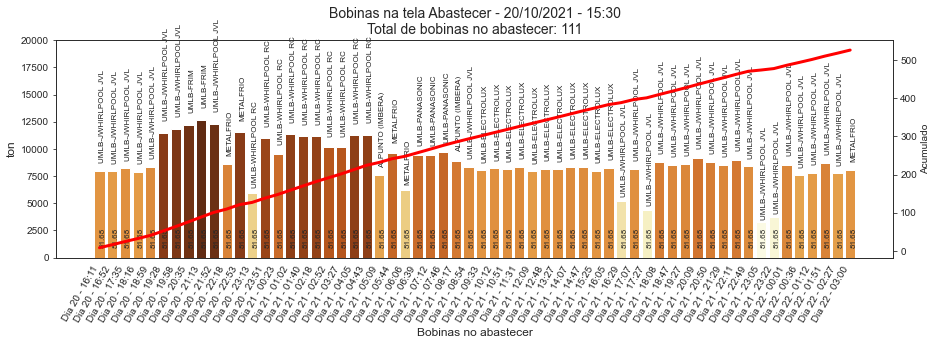

In [10]:
abastecer = df_abastecer

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(60)

y = abastecer['Peso (kg)']

sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Peso (kg)'] = abastecer['Peso (kg)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Peso (kg)', data = abastecer, ax=ax, palette = colors_from_values(y, "YlOrBr"))
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('ton', fontsize=12)

x = abastecer.index
y1 = abastecer['Peso (kg)']
y2 = abastecer['Clientes'].to_list()
abastecer['Velocidade_padrao'] = abastecer['Velocidade_padrao'].apply(str)
y3 = abastecer['Velocidade_padrao'].to_list()


ax.set(ylim=(0, 20000))

y1_text = y1.max()*0.05

for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=8)
    ax.text(i ,1000, y3[i],rotation=90,fontsize=8)
    
    
ax1 = ax.twinx()

aba = abastecer
aba['Acumulado'] = aba['Peso (kg)'].cumsum()
aba['Acumulado'] = aba['Acumulado']/1000
sns.lineplot(x='Prev_Prod', y = 'Acumulado', data = aba, ax=ax1, color = 'red', linewidth  = 3)

## Bobinas no abastecer por cliente e larguras

<AxesSubplot:label='1ef67486-740b-4783-b920-60401a2932e8', xlabel='Prev_Prod', ylabel='Acumulado'>

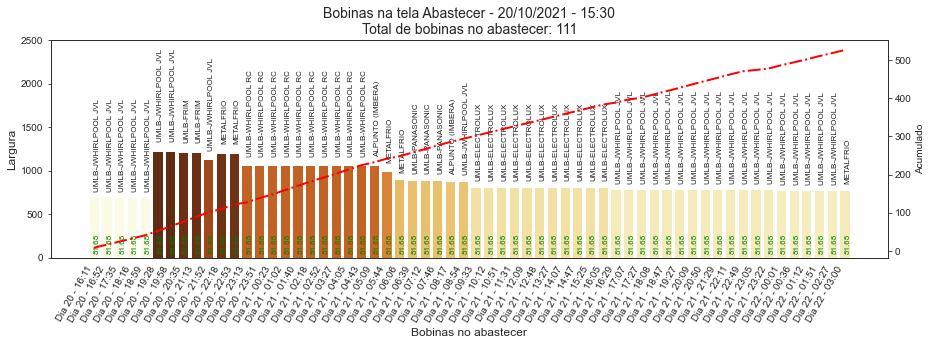

In [11]:
abastecer = df_abastecer

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(60)


y = abastecer['Larg. (mm)']

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = colors_from_values(y, "YlOrBr"))
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)


x = abastecer.index
y1 = abastecer['Larg. (mm)']
y2 = abastecer['Clientes'].to_list()
abastecer['Velocidade_padrao'] = abastecer['Velocidade_padrao'].apply(str)
y3 = abastecer['Velocidade_padrao'].to_list()


y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=8)
    ax.text(i ,50, y3[i],rotation=90,fontsize=8,color = 'green')
   
ax.set(ylim=(0, 2500))

ax1 = ax.twinx()

aba = abastecer
aba['Acumulado'] = aba['Peso (kg)'].cumsum()
aba['Acumulado'] = aba['Acumulado']/1000
sns.lineplot(x='Prev_Prod', y = 'Acumulado', data = aba, ax=ax1, color = 'red', linestyle='-.',linewidth  = 2)

## Bobinas no abastecer por sequenciamento de espessura

<AxesSubplot:label='a0339246-c272-422f-855f-7108f7f14e41', xlabel='Prev_Prod', ylabel='Acumulado'>

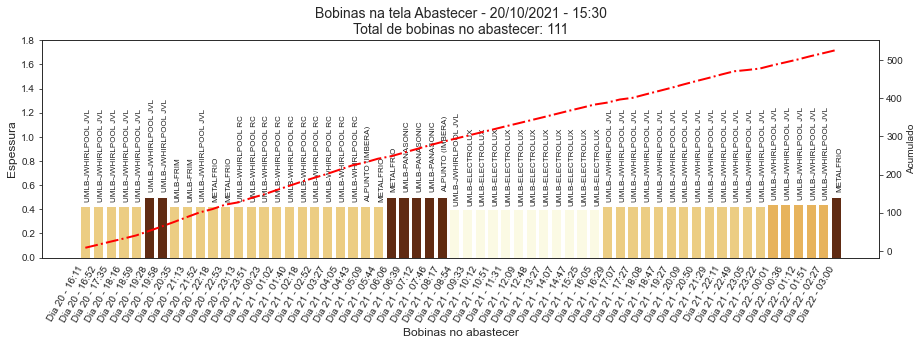

In [12]:
abastecer = df_abastecer

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(60)


y = abastecer['Esp. (mm)']

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Esp. (mm)'] = abastecer['Esp. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Esp. (mm)', data = abastecer, ax=ax, palette = colors_from_values(y, "YlOrBr"))
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Espessura', fontsize=12)


x = abastecer.index
y1 = abastecer['Esp. (mm)']
y2 = abastecer['Clientes'].to_list()
abastecer['Velocidade_padrao'] = abastecer['Velocidade_padrao'].apply(str)
y3 = abastecer['Velocidade_padrao'].to_list()


y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=8)
   
ax.set(ylim=(0, 1.8))

ax1 = ax.twinx()

aba = abastecer
aba['Acumulado'] = aba['Peso (kg)'].cumsum()
aba['Acumulado'] = aba['Acumulado']/1000
sns.lineplot(x='Prev_Prod', y = 'Acumulado', data = aba, ax=ax1, color = 'red', linestyle='-.',linewidth  = 2)

In [13]:
def cores_col(df,coluna):
        
    df['palette'] = 'tomato'
    df.loc[df[coluna].str.contains('BRANCO',case=False),'palette'] = 'ghostwhite'
    df.loc[df[coluna].str.contains('BRANCA',case=False),'palette'] = 'ghostwhite'
    df.loc[df[coluna].str.contains('WHITE',case=False),'palette'] = 'ghostwhite'  
    df.loc[df[coluna].str.contains('AZUL',case=False),'palette'] = 'b'
    df.loc[df[coluna].str.contains('BEGE',case=False),'palette'] = 'gold'
    df.loc[df[coluna].str.contains('CINZA',case=False),'palette'] = 'gray'
    df.loc[df[coluna].str.contains('VERDE',case=False),'palette'] = 'g'
    df.loc[df[coluna].str.contains('VERMELHO',case=False),'palette'] = 'r'
    df.loc[df[coluna].str.contains('PRETA',case=False),'palette'] = 'k'
    df.loc[df[coluna].str.contains('PRATA',case=False),'palette'] = 'silver'
    df.loc[df[coluna].str.contains('AMARELO',case=False),'palette'] = 'yellow'
    df.loc[df[coluna].str.contains('MARROM',case=False),'palette'] = 'chocolate'
    df.loc[df[coluna].str.contains('LARANJA',case=False),'palette'] = 'orange'
    df.loc[df[coluna].str.contains('GRAFITE',case=False),'palette'] = 'rosybrown'
    
    return df

In [14]:
spec = bann.abre_spec()
spec = spec[['Sistema','Tinta Sup.','Tinta Inf.','Tinta Primer']]
spec = spec.rename(columns ={'Sistema':'Sistema Pintura'})
df_abastecer_c = pd.merge(df_abastecer,spec, how='left', on=['Sistema Pintura'])


## Bobinas no abastecer com a percepção de cores programadas

[(0.0, 3000.0)]

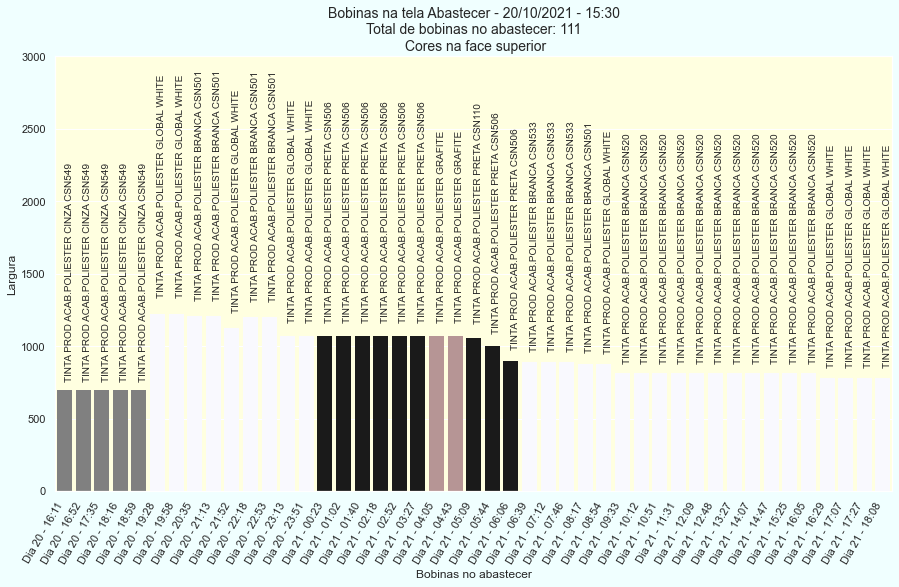

In [15]:
df = df_abastecer_c
cores = cores_col(df,'Tinta Sup.')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(45)

cores = abastecer['palette'].tolist()

sns.set(rc={'axes.facecolor':'lightyellow', 'figure.facecolor':'azure'})


f, ax = plt.subplots(figsize=(15,8)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores,color = 'g')

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Cores na face superior'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)


x = abastecer.index
y1 = abastecer['Larg. (mm)']
y2 = abastecer['Tinta Sup.'].to_list()
abastecer['Velocidade_padrao'] = abastecer['Velocidade_padrao'].apply(str)
y3 = abastecer['Velocidade_padrao'].to_list()


y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=10)    
  
ax.set(ylim=(0, 3000))



## Bobinas no abastecer com alteração do sistema de pintura

[(0.0, 1750.0)]

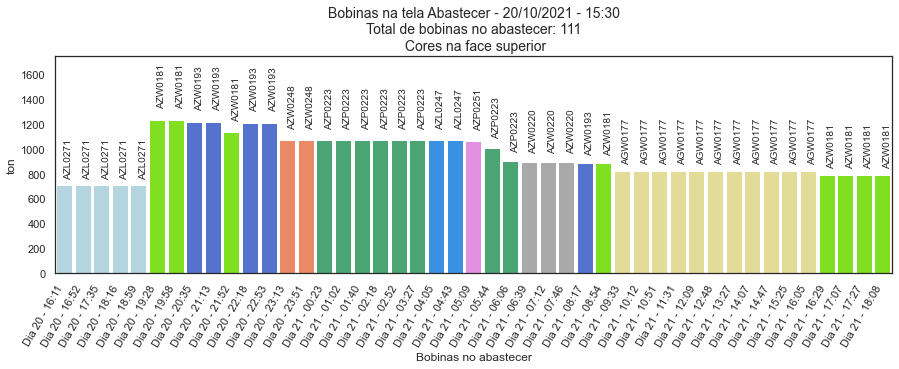

In [16]:
lista_cores = ['lightblue','chartreuse','royalblue','coral',
               'mediumseagreen','dodgerblue','violet',
               'darkgray','khaki','aqua',
               'magenta','sienna','gold',
               'darkgreen','orange','darkblue',
               'lightgreen','salmon','beige',
               'blueviolet','gray','maroon']

df = df_abastecer_c
cores = cores_col(df,'Tinta Sup.')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(45)


cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])
cores_unicas['ID_cor'] = range(0,cores_unicas.shape[0])

palette_bann = pd.DataFrame(lista_cores,columns=['Lista Cor'])
palette_bann['ID_cor'] = range(0,palette_bann.shape[0])


cores_unicas = pd.merge(cores_unicas,palette_bann,how = 'left', on = ['ID_cor'])

abastecer = pd.merge(abastecer,cores_unicas,how = 'left', on = ['Sistema Pintura'])
cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])

cores = abastecer['Lista Cor'].tolist()


y = abastecer['ID_cor']

sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores)

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Cores na face superior'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('ton', fontsize=12)


x = abastecer.index
y1 = abastecer['Larg. (mm)']
y2 = abastecer['Sistema Pintura'].to_list()



y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=10)    
  
ax.set(ylim=(0, 1750))

## Bobinas no abastecer com alteração da cor na face superior

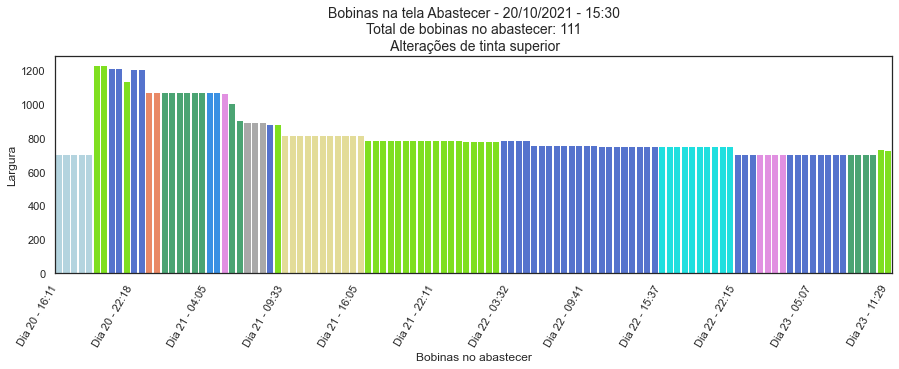

In [17]:
lista_cores = ['lightblue','chartreuse','royalblue','coral',
               'mediumseagreen','dodgerblue','violet',
               'darkgray','khaki','aqua',
               'magenta','sienna','gold',
               'darkgreen','orange','darkblue',
               'lightgreen','salmon','beige',
               'blueviolet','gray','maroon']

df = df_abastecer_c
cores = cores_col(df,'Tinta Sup.')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
#abastecer = abastecer.head(60)


cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])
cores_unicas['ID_cor'] = range(0,cores_unicas.shape[0])

palette_bann = pd.DataFrame(lista_cores,columns=['Lista Cor'])
palette_bann['ID_cor'] = range(0,palette_bann.shape[0])


cores_unicas = pd.merge(cores_unicas,palette_bann,how = 'left', on = ['ID_cor'])

abastecer = pd.merge(abastecer,cores_unicas,how = 'left', on = ['Sistema Pintura'])
cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])

cores = abastecer['Lista Cor'].tolist()


y = abastecer['ID_cor']

sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores)

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Alterações de tinta superior'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))


## Bobinas no abastecer com alteração de cor na face inferior - primeiras 60 bobinas

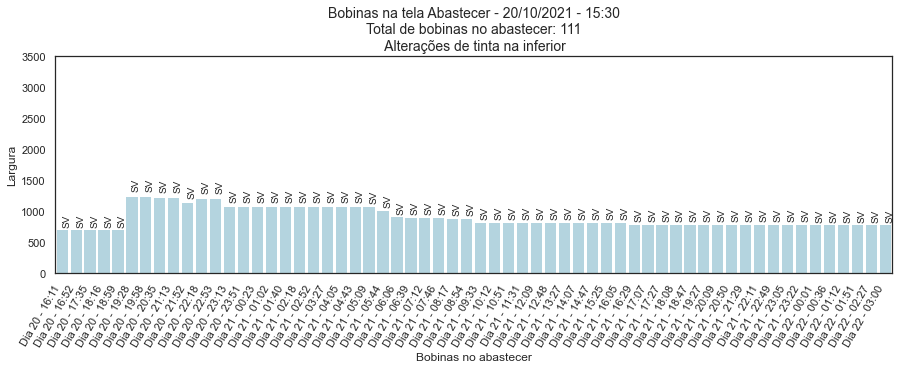

In [18]:
lista_cores = ['lightblue','chartreuse','royalblue','coral',
               'mediumseagreen','dodgerblue','violet',
               'darkgray','khaki','aqua',
               'magenta','sienna','gold',
               'darkgreen','orange','darkblue',
               'lightgreen','salmon','beige',
               'blueviolet','gray','maroon']

df = df_abastecer_c
cores = cores_col(df,'Tinta Inf.')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
abastecer = abastecer.head(60)


cores_unicas = pd.DataFrame(abastecer['Tinta Inf.'].unique(),columns=['Tinta Inf.'])
cores_unicas['ID_cor'] = range(0,cores_unicas.shape[0])

palette_bann = pd.DataFrame(lista_cores,columns=['Lista Cor'])
palette_bann['ID_cor'] = range(0,palette_bann.shape[0])


cores_unicas = pd.merge(cores_unicas,palette_bann,how = 'left', on = ['ID_cor'])

abastecer = pd.merge(abastecer,cores_unicas,how = 'left', on = ['Tinta Inf.'])
cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])

cores = abastecer['Lista Cor'].tolist()


y = abastecer['ID_cor']

sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores)

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Alterações de tinta na inferior'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)

#ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.set(ylim=(0, 3500))

x = abastecer.index
y1 = abastecer['Larg. (mm)']
y2 = abastecer['Tinta Inf.'].to_list()

y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=10)  

## Bobinas no abastecer com alteração do sistema de pintura - todas as bobinas

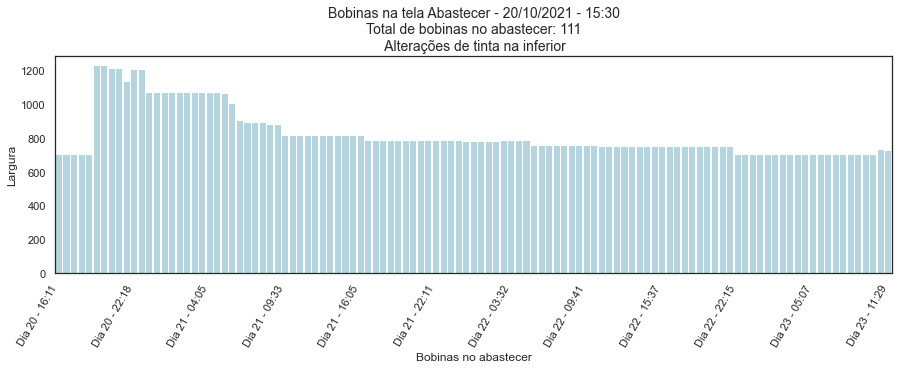

In [19]:
lista_cores = ['lightblue','chartreuse','royalblue','coral',
               'mediumseagreen','dodgerblue','violet',
               'darkgray','khaki','aqua',
               'magenta','sienna','gold',
               'darkgreen','orange','darkblue',
               'lightgreen','salmon','beige',
               'blueviolet','gray','maroon']

df = df_abastecer_c
cores = cores_col(df,'Tinta Inf.')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
#abastecer = abastecer.head(60)


cores_unicas = pd.DataFrame(abastecer['Tinta Inf.'].unique(),columns=['Tinta Inf.'])
cores_unicas['ID_cor'] = range(0,cores_unicas.shape[0])

palette_bann = pd.DataFrame(lista_cores,columns=['Lista Cor'])
palette_bann['ID_cor'] = range(0,palette_bann.shape[0])


cores_unicas = pd.merge(cores_unicas,palette_bann,how = 'left', on = ['ID_cor'])

abastecer = pd.merge(abastecer,cores_unicas,how = 'left', on = ['Tinta Inf.'])
cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])

cores = abastecer['Lista Cor'].tolist()


y = abastecer['ID_cor']

sns.set_style("white")
f, ax = plt.subplots(figsize=(15,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores)

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Alterações de tinta na inferior'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

## Segmento de Produção

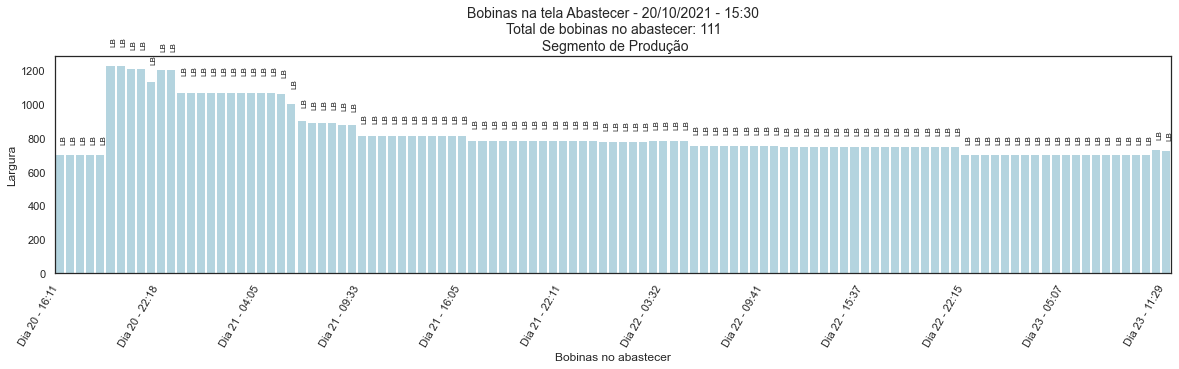

In [20]:
lista_cores = ['lightblue','chartreuse','royalblue','coral',
               'mediumseagreen','dodgerblue','violet',
               'darkgray','khaki','aqua',
               'magenta','sienna','gold',
               'darkgreen','orange','darkblue',
               'lightgreen','salmon','beige',
               'blueviolet','gray','maroon']

df = df_abastecer_c
cores = cores_col(df,'Segmento')


abastecer = df_abastecer_c

quantidade = str(abastecer.shape[0])
#abastecer = abastecer.head(60)


cores_unicas = pd.DataFrame(abastecer['Segmento'].unique(),columns=['Segmento'])
cores_unicas['ID_cor'] = range(0,cores_unicas.shape[0])

palette_bann = pd.DataFrame(lista_cores,columns=['Lista Cor'])
palette_bann['ID_cor'] = range(0,palette_bann.shape[0])


cores_unicas = pd.merge(cores_unicas,palette_bann,how = 'left', on = ['ID_cor'])

abastecer = pd.merge(abastecer,cores_unicas,how = 'left', on = ['Segmento'])
cores_unicas = pd.DataFrame(abastecer['Sistema Pintura'].unique(),columns=['Sistema Pintura'])

cores = abastecer['Lista Cor'].tolist()


y = abastecer['ID_cor']

sns.set_style("white")
f, ax = plt.subplots(figsize=(20,4)) 
abastecer['Larg. (mm)'] = abastecer['Larg. (mm)'].apply(pd.to_numeric, errors='coerce')
sns.barplot(x='Prev_Prod', y = 'Larg. (mm)', data = abastecer, ax=ax, palette = cores)

plt.setp(ax.patches, linewidth=0)
plt.xticks(rotation=60, horizontalalignment='right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

titulo = 'Bobinas na tela Abastecer - ' + hoje + '\nTotal de bobinas no abastecer: ' + quantidade + '\n Segmento de Produção'
ax.set_title(titulo, fontsize=14)
ax.set_xlabel('Bobinas no abastecer', fontsize=12)
ax.set_ylabel('Largura', fontsize=12)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

x = abastecer.index
y1 = abastecer['Larg. (mm)']
y2 = abastecer['Segmento'].to_list()

y1_text = y1.max()*0.05
for i, v in enumerate(y1):
    ax.text(i ,v*1.1, y2[i],rotation=90,fontsize=8)  